### The papers used in this script are from an unknown group of papers given by my instructor, mostly related to energy, supply chain, urban system and etc. 

In [7]:
!pip install pycountry PyPDF2 nltk gensim seaborn
from matplotlib import pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import gensim
import pycountry
import os
import PyPDF2
from pprint import pprint
import re
import json
import requests
from google.colab import drive
from gensim import corpora
import seaborn as sns
import numpy as np
from gensim.models import LdaModel, CoherenceModel

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
drive.mount('/content/drive')

# Adjust parameters for new data
path_to_files = '/2023' # path folder containing the files in google drive



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
os.listdir('drive/MyDrive/MahYingQi/Code')
list_of_folders = [str(i) for i in range(2014,2024)]

Preprocess the output of api call to get the required data.

In [ ]:

def process_response(response, doi, file):
    '''
    Process the response from the Scopus API and return a dictionary with the relevant information
    '''
    response = response.json()
    try:
        # Create a DataFrame with the relevant information from the response
        dfs = pd.DataFrame(
            {
                'FileName': [str(file)],
                'Title': [response['search-results']['entry'][0]['dc:title']],
                'Abstract': [response['search-results']['entry'][0]['dc:description']],
                'Authors': [response['search-results']['entry'][0]['author'][0]['authname']],
                'Country': [response['search-results']['entry'][0]['affiliation'][0]['affiliation-country']],
                'Affiliation': [response['search-results']['entry'][0]['affiliation'][0]['affilname']],
                'Publisher': [response['search-results']['entry'][0]['prism:publicationName']],
                'Year': [int(response['search-results']['entry'][0]['prism:coverDate'][:4])],
                'Cite': [int(response['search-results']['entry'][0]['citedby-count'])],
                'doi': [response['search-results']['entry'][0]['prism:doi']]
            }
        )
    except Exception as e:
        # If there is an error, create a DataFrame with the error message and None for other fields
        dfs = pd.DataFrame(
            {
                'FileName': [str(file)],
                'Title': [str(e)],
                'Abstract': [None],
                'Authors': [None],
                'Country': [None],
                'Affiliation': [None],
                'Publisher': [None],
                'Year': [None],
                'Cite': [None],
                'doi': [doi],
            }
        )

    return dfs

Call scopus API to get the data for the given author id. Of course, you can precollect the data and store it in a file and skip this step.

In [ ]:

header = {
    "Accept": "application/json",
    "X-ELS-APIKey":"<your-scopus-api-key>", # My API Key
    "X-ELS-Insttoken":"<your-scopus-institution-key>" # My Instiution Token
}
result = pd.DataFrame()
for i in list_of_folders:
    list_of_files = os.listdir('drive/MyDrive/MahYingQi/Code/'+i)

    count = 0
    file_to_info = {}
    files_info = []
    for file in list_of_files:
        with open("drive/MyDrive/MahYingQi/Code/"+i+"/"+file, "rb") as f:
            print("Processing file: ", file, end=' ')
            # read first page of the pdf
            pdf = PyPDF2.PdfReader(f)
            page = pdf.pages[0]

            # extract DOI from the page
            exp = "10.\\d{4,9}/[-._;()/:a-z0-9A-Z]+"
            pattern = re.compile(exp)
            doi = pattern.findall(page.extract_text())
            print("Doi: ",doi)
            if doi:
                doi = doi[0]

                # make a request to the Scopus API
                url = "https://api.elsevier.com/content/search/scopus?query=DOI(\"{}\")&view=COMPLETE".format(doi)
                response = requests.get(url, headers=header)

                # process the response
                files_info.append(process_response(response,doi, file))
                count += 1
            else:
                files_info.append(pd.DataFrame(
                {
                    'FileName':[str(file)],
                'Title': ['File not found'],
                'Abstract': [None],
                'Authors': [None],
                'Country': [None],
                'Affiliation' : [None],
                'Publisher': [None],
                'Year': [None],
                'Cite': [None],
                'doi':[doi],
                }
            ))


    print("File processed: ", count)
    print("Files without DOI: ", len(list_of_files) - count)
    print("Total files: ", len(list_of_files))
    result = pd.concat(files_info+[result])

print(result.head())




Processing file:  237.pdf Doi:  ['10.1016/j.energy.2014.06.109']
Processing file:  239.pdf Doi:  ['10.1016/j.ijpe.2013.12.012']
Processing file:  238.pdf Doi:  ['10.1016/j.buildenv.2013.10.009Building']
File processed:  3
Files without DOI:  0
Total files:  3
Processing file:  224.pdf Doi:  ['10.1016/j.apenergy.2015.01.069']
Processing file:  227.pdf Doi:  ['10.1016/j.jclepro.2014.11.058']
Processing file:  228.pdf Doi:  ['10.1016/j.energy.2015.06.099']
Processing file:  235.pdf Doi:  ['10.1016/j.jclepro.2013.11.004Journal']
Processing file:  231.pdf Doi:  ['10.1016/j.ijpe.2015.04.016']
Processing file:  229.pdf Doi:  ['10.1016/j.jclepro.2015.03.026']
Processing file:  233.pdf Doi:  ['10.1111/ecge.12095', '10.1111/ecge.12095']
Processing file:  225.pdf Doi:  ['10.1016/j.apenergy.2015.01.126']
Processing file:  236.pdf Doi:  ['10.1016/j.resconrec.2015.04.009']
Processing file:  234.pdf Doi:  ['10.1016/j.energy.2015.03.029']
Processing file:  226.pdf Doi:  ['10.1016/j.ijpe.2014.08.015']


In [ ]:
with open('result.csv','w') as F:
  result.to_csv(F)

Analyzing trends and patterns in the research paper data for exploration and visualization

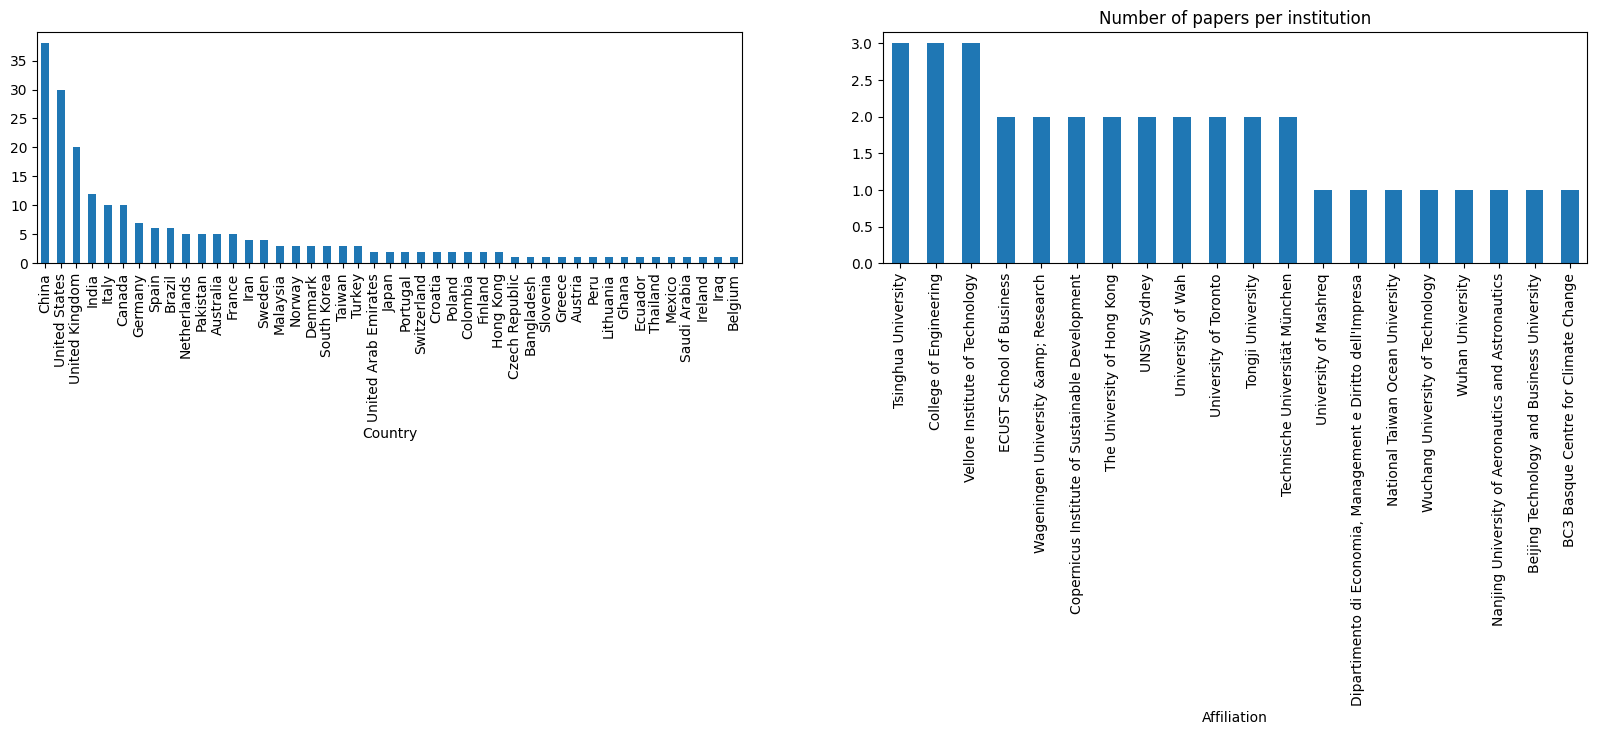

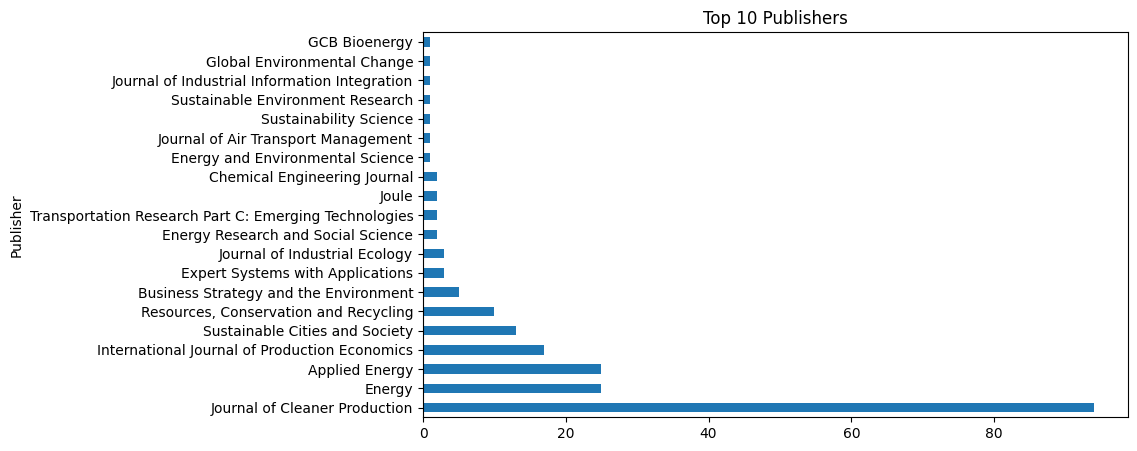

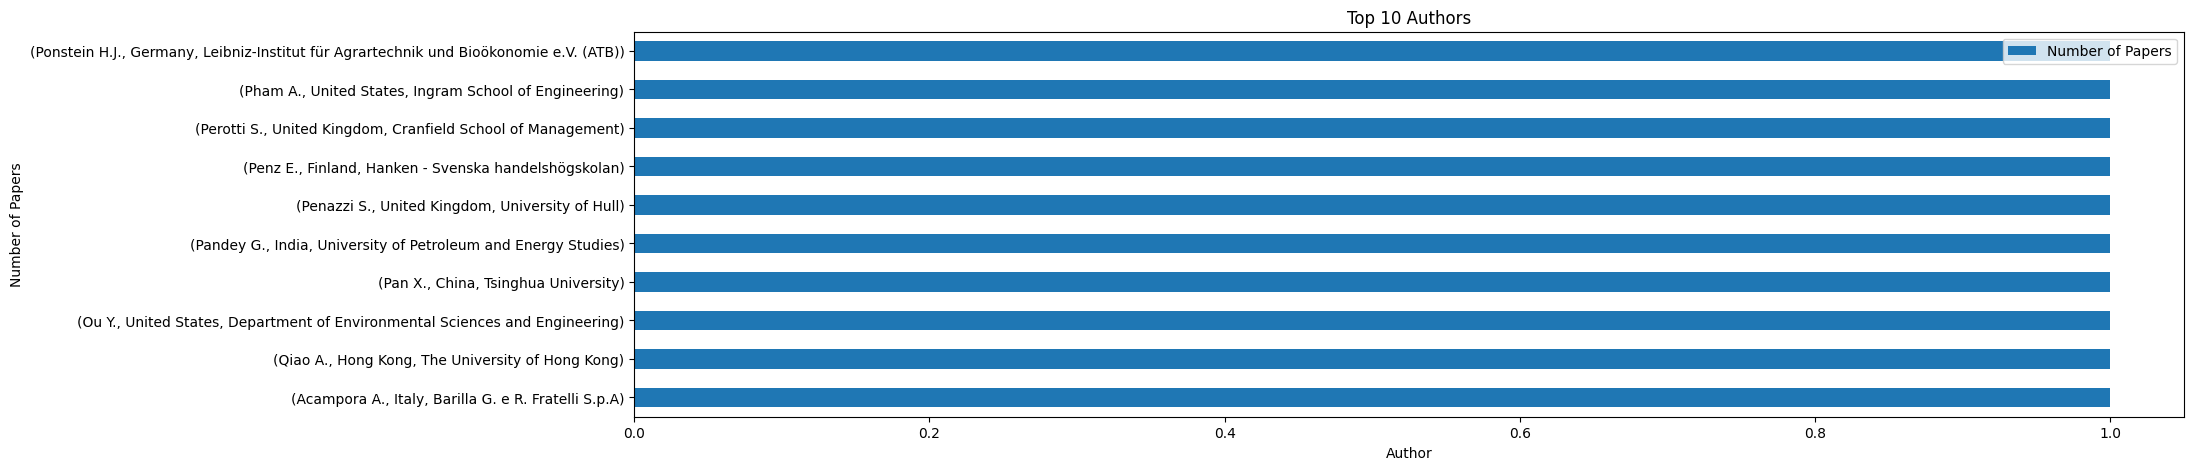

<Figure size 2000x500 with 0 Axes>

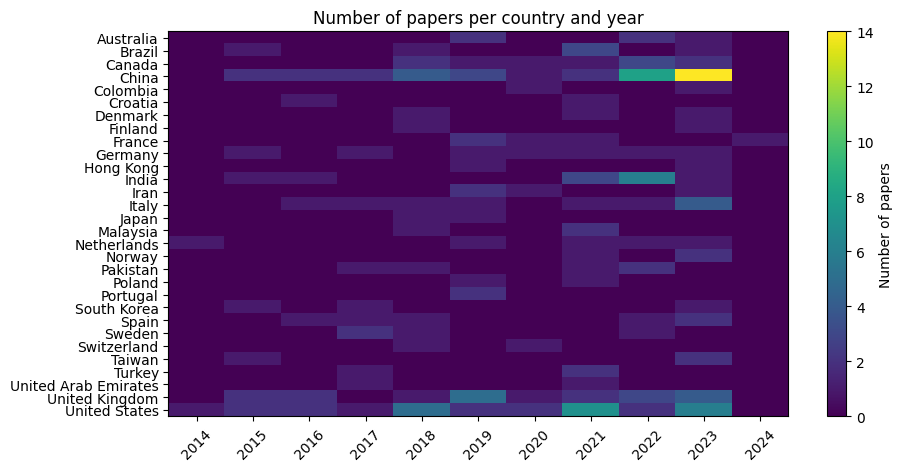

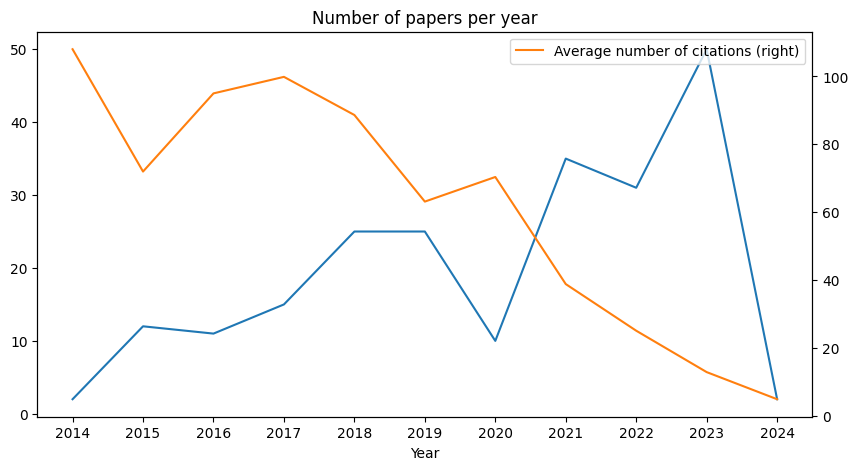

In [ ]:
"""
Showing trends and statistics
"""
papers = result
papers.dropna(subset=['Abstract'], inplace=True, ignore_index=True)

country_counts = papers['Country'].value_counts()
plt.figure(figsize=(20, 3))
plt.subplot(1,2,1)

# country_counts = country_counts[country_counts > 50]
country_counts.plot(kind='bar')


plt.subplot(1,2,2)
institution_counts = papers['Affiliation'].value_counts().sort_values(ascending=False)[:20]
institution_counts.plot(kind='bar')
plt.title('Number of papers per institution')

plt.show()
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
publisher = papers['Publisher'].value_counts().sort_values(ascending=False)[:20]
publisher.plot(kind='barh')
plt.title('Top 10 Publishers')
plt.show()


plt.figure(figsize=(20, 5))
author_count = papers.groupby(['Authors', 'Country', 'Affiliation'])
author_count = author_count['Authors'].count().sort_values(ascending=False)[:10]
author_count.plot(kind='barh')
plt.title('Top 10 Authors')
plt.legend(['Number of Papers'])
plt.title('Top 10 Authors')
plt.xlabel('Author')
plt.ylabel('Number of Papers')
plt.show()
plt.figure(figsize=(20, 5))


plt.show()


country_year_counts = papers.groupby(['Country', 'Year']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 1]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
plt.figure(figsize=(10,5))
plt.imshow(country_year_counts, aspect='auto')
plt.yticks(range(len(country_year_counts)), country_year_counts.index)
plt.xticks(range(len(country_year_counts.columns)), country_year_counts.columns, rotation=45)
plt.title('Number of papers per country and year')
plt.colorbar(label='Number of papers')
plt.show()

count = papers.groupby('Year').count()

avg_cite = papers.groupby('Year')['Cite'].mean()
plt.figure(figsize=(10,5))
plt.plot(count.index, count['Title'], label='Number of papers')
avg_cite.plot(label='Average number of citations', secondary_y=True)
plt.title('Number of papers per year')
plt.xticks(count.index)
plt.legend()
plt.show()


## Prprocess natural language data

In [ ]:
papers['Abstract'] = papers['Abstract'].str.lower()

papers['Abstract'] = papers.Abstract.apply(nltk.word_tokenize)

papers['Abstract'] = papers.Abstract.apply(lambda x: [item for item in x if item.isalpha()])

stop_words = set(stopwords.words('english'))
papers['Abstract'] = papers.Abstract.apply(lambda x: [item for item in x if item not in stop_words])

lemmatizer = WordNetLemmatizer()
papers['Abstract'] = papers.Abstract.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])


bigram = gensim.models.Phrases(papers['Abstract'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(papers['Abstract'], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
papers['Abstract'] = make_bigrams(papers['Abstract'])
papers['Abstract'] = make_trigrams(papers['Abstract'])
papers.reset_index(drop=True, inplace=True)
word_lists = [papers['Abstract'][i] for i in range(len(papers))]
id2word = corpora.Dictionary(word_lists)

corpus = [id2word.doc2bow(word) for word in word_lists]


# Find the optimal number of topics using coherence score



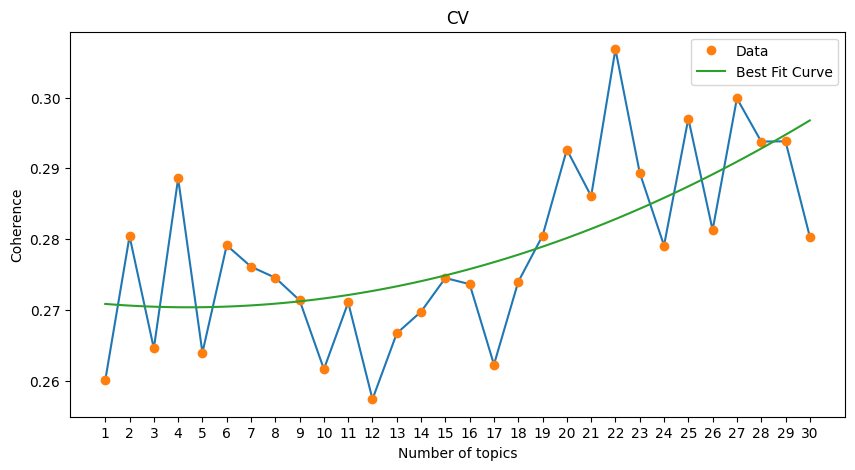

In [ ]:

topic_count = [i for i in range(1, 31)]
perplexity = []
coherence_cv = []
coherence_umass = []
for i in topic_count:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, random_state=100, passes=20, chunksize=len(corpus), alpha='auto', eta='auto')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_lists, dictionary=id2word, coherence='c_v')
    coherence_cv.append(coherence_model_lda.get_coherence())

plt.figure(figsize=(10,5))
plt.plot(topic_count, coherence_cv)
plt.xlabel('Number of topics')
# Fit a polynomial curve to the data
coefficients = np.polyfit(topic_count, coherence_cv, 2)
poly = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(min(topic_count), max(topic_count), 100)

# Plot the curve
plt.plot(topic_count, coherence_cv, 'o', label='Data')
plt.plot(x, poly(x), label='Best Fit Curve')

plt.xlabel('Number of topics')
plt.xticks(topic_count)
plt.ylabel('Coherence')
plt.title('CV')
plt.legend()
plt.show()



## Perform topic modelling, show the probability of each topic and the word cloud for each topic

#### Analyze the topics type using the word cloud


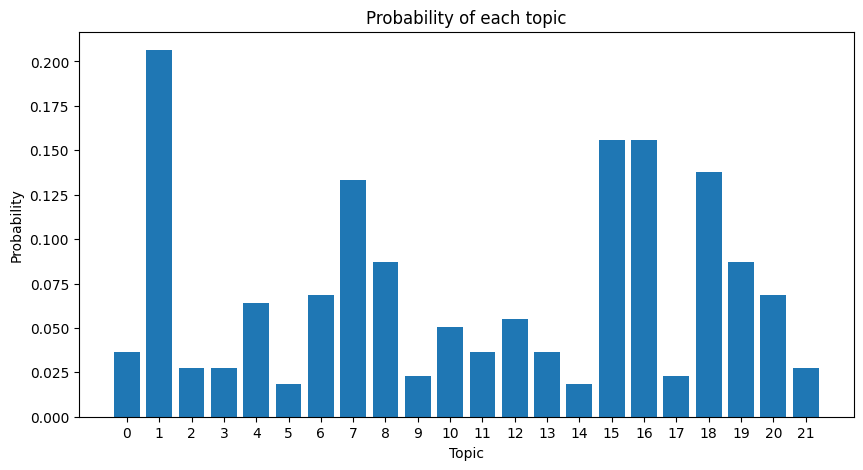

Keywords For Each Topic
[(0, '0.021*"data" + 0.012*"kg" + 0.009*"artichoke" + 0.009*"chain" + 0.009*"emission" + 0.008*"sustainability" + 0.008*"supply" + 0.008*"transportation" + 0.008*"study" + 0.007*"environmental"'), (1, '0.023*"emission" + 0.020*"carbon" + 0.016*"vehicle" + 0.012*"supply" + 0.011*"result" + 0.011*"transportation" + 0.010*"chain" + 0.009*"electric" + 0.008*"energy" + 0.008*"study"'), (2, '0.015*"emission" + 0.013*"reuse" + 0.012*"recycling" + 0.011*"lsp" + 0.011*"network" + 0.010*"part" + 0.009*"transportation" + 0.009*"product" + 0.009*"carbon" + 0.009*"system"'), (3, '0.014*"cost" + 0.010*"fuel" + 0.010*"local" + 0.008*"delivery" + 0.007*"carbon" + 0.007*"lhv" + 0.006*"emission" + 0.006*"decarbonization" + 0.006*"petroleum" + 0.006*"price"'), (4, '0.013*"vehicle" + 0.013*"emission" + 0.012*"model" + 0.011*"fuel" + 0.011*"transportation" + 0.011*"technology" + 0.008*"electricity" + 0.007*"energy" + 0.007*"supply" + 0.007*"digital"'), (5, '0.032*"carbon" + 0.015*"f

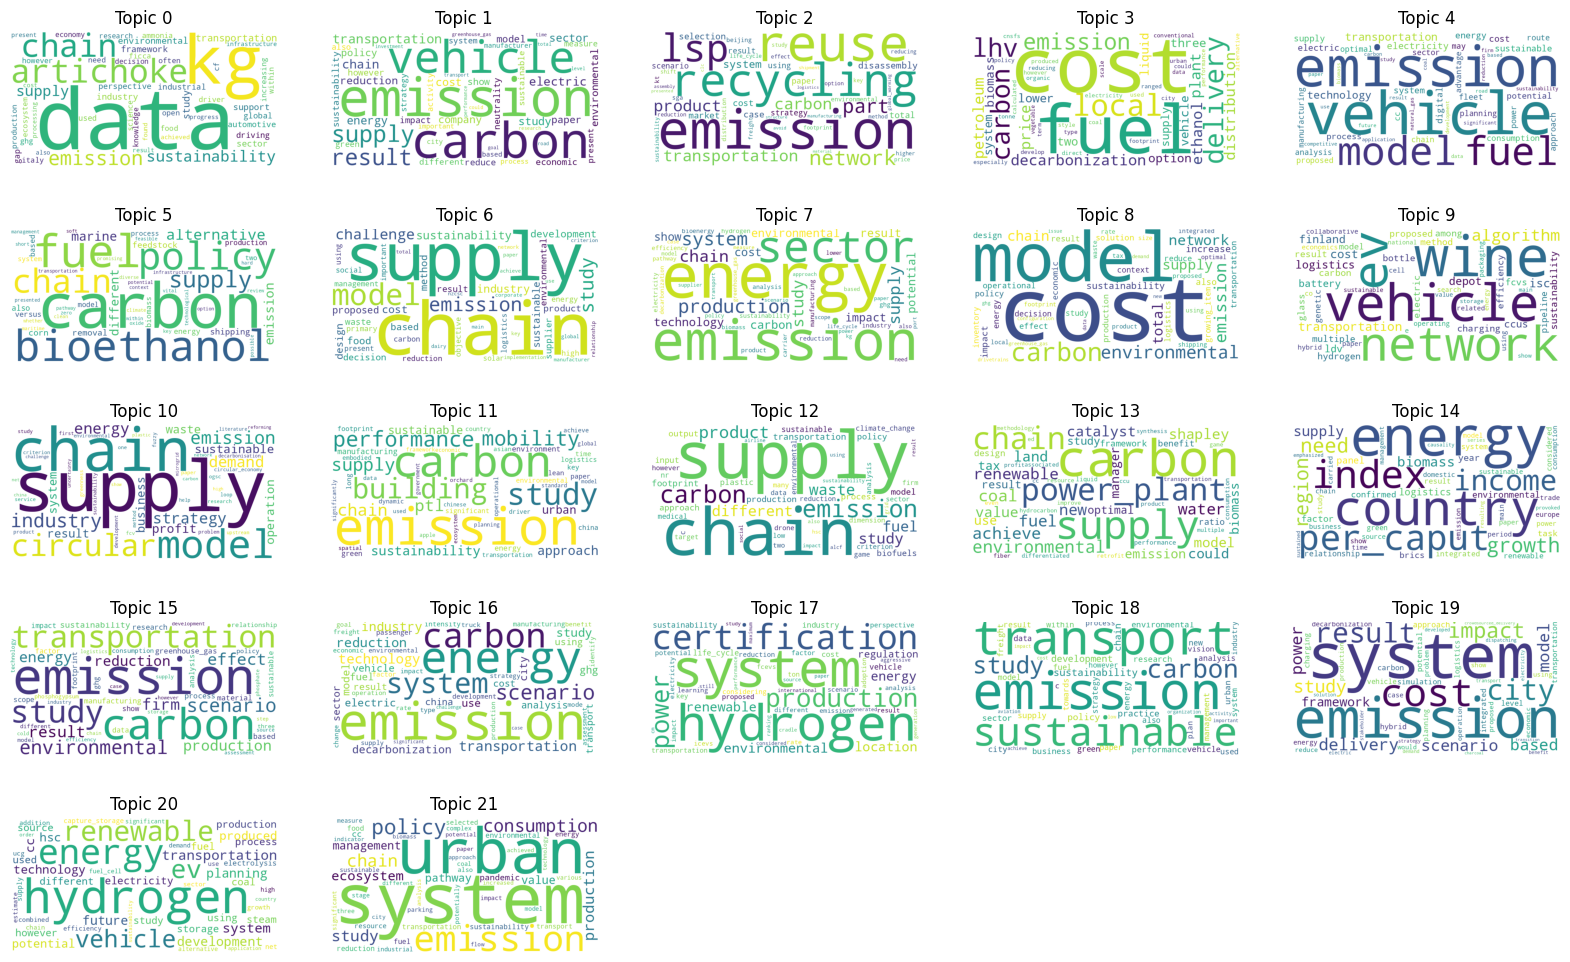

In [ ]:


number_of_topics = 15

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=number_of_topics,chunksize=1000, alpha='auto', eta='auto', random_state=100, passes=10)
all_topics = lda_model.print_topics()

docs_per_topic = [[] for _ in range(lda_model.num_topics)]

for doc_id, doc_bow in enumerate(corpus):
    doc_topics = lda_model.get_document_topics(doc_bow)
    for topic, prob in doc_topics:
        docs_per_topic[topic].append((doc_id, prob))

count_per_topic = [len(topic) for topic in docs_per_topic]
probabilities_per_topic = [len(topic)/len(word_lists) for topic in docs_per_topic]

plt.figure(figsize=(10,5))
plt.bar(range(len(probabilities_per_topic)),probabilities_per_topic)
plt.xticks(range(len(probabilities_per_topic)))
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Probability of each topic')
plt.show()

print("Keywords For Each Topic")
print(lda_model.print_topics(num_topics=lda_model.num_topics))

from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = [20, 20]



wc = WordCloud(background_color='white',width=800, height=400)
for i in range(lda_model.num_topics):
    plt.subplot(8,5,i+1)
    wc = WordCloud(background_color='white',width=800, height=400)
    plt.imshow(wc.fit_words(dict(lda_model.show_topic(i,50))))
    plt.title('Topic {}'.format(i))
    plt.axis('off')

top_doc_per_topic = [sorted(topic, key=lambda x:x[1], reverse=True) for topic in docs_per_topic]
topic_df = pd.DataFrame(columns=['Title', 'Abstract', 'Topic'])

topic_year = [{} for _ in range(lda_model.num_topics)]
dfs = []
probabilities = []
for i, docs in enumerate(top_doc_per_topic):
    probabilities.append(sum([prob for (doc, prob) in docs[:10]])/10)
    topic_df = pd.DataFrame()
    for doc, prob in docs:
        topic_year[i][papers['Year'][doc]] = topic_year[i].get(papers['Year'][doc], 0) + 1
        topic_df = pd.concat([topic_df, pd.DataFrame({
                'Title': [papers['Title'][doc]],
                'Abstract': [papers['Abstract'][doc]],
                'Topic': [i],
                'Citations':[papers['Cite'][doc]],
                'Probability':[prob],
                'Country':[papers['Country'][doc]],
                'Publisher':[papers['Publisher'][doc]],
                })], ignore_index=True)
    dfs.append(topic_df)

final_topic_df = pd.concat(dfs)





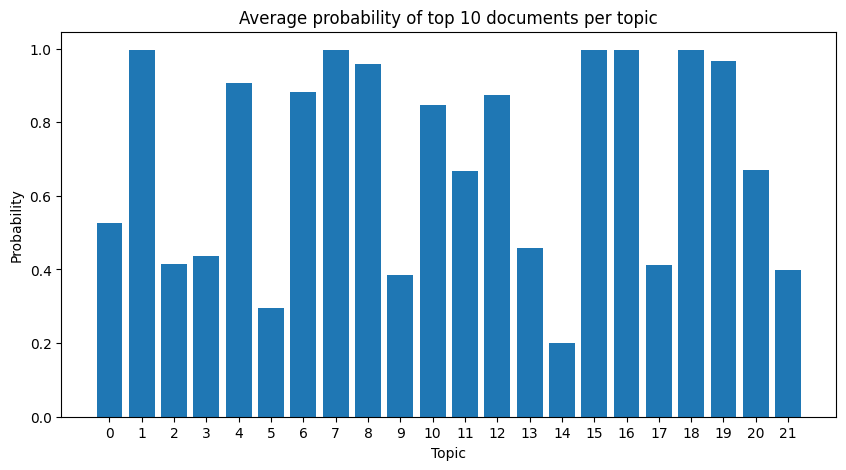

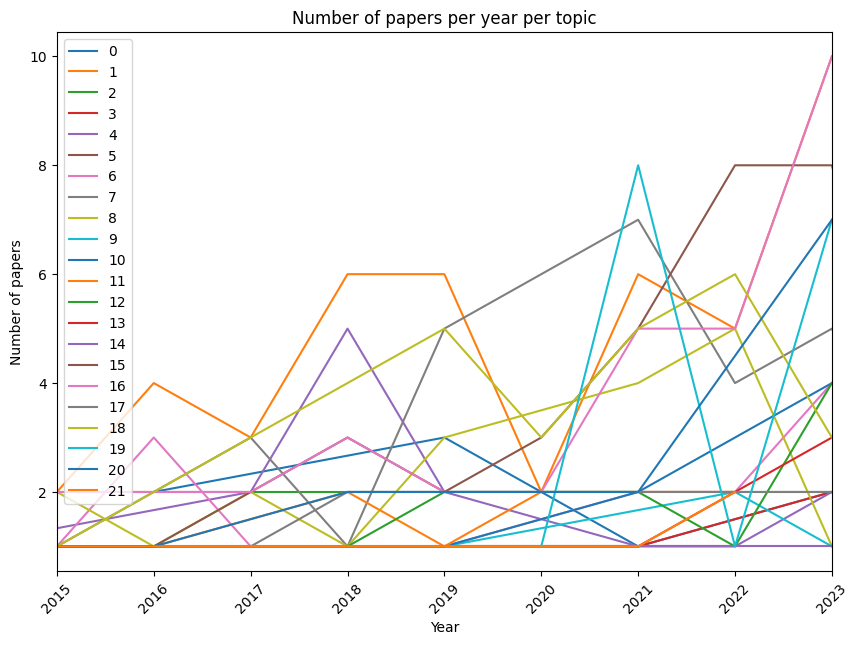

In [ ]:
"""
Show the average probability of top 10 documents per topic
"""
plt.figure(figsize=(10,5))
plt.bar(range(0,number_of_topics),probabilities)
plt.title('Average probability of top 10 documents per topic')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.xticks(range(0,number_of_topics))
plt.show()

"""
Show the number of papers per year per topic
"""
plt.figure(figsize=(10,7))
min_year = 2015
for i in range(len(topic_year)):
    topic_year[i] = {k: v for k, v in sorted(topic_year[i].items(), key=lambda item: item[0])}

topic_year =

plt.xlim(min_year,2023)
plt.xticks(range(min_year,2024), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of papers')
plt.title('Number of papers per year per topic')
plt.legend(range(number_of_topics))
plt.show()

## Print the top 10 papers per topic

### If you do not want to use open API for this part, you can just paste this part in ChatGPT with the prompt:

"These are the LDA top words for the topic `<your-topic>`, please give a possible topic area name for each group."

In [ ]:
lda_model.print_topics(number_of_topics)

[(0,
  '0.021*"data" + 0.012*"kg" + 0.009*"artichoke" + 0.009*"chain" + 0.009*"emission" + 0.008*"sustainability" + 0.008*"supply" + 0.008*"transportation" + 0.008*"study" + 0.007*"environmental"'),
 (1,
  '0.023*"emission" + 0.020*"carbon" + 0.016*"vehicle" + 0.012*"supply" + 0.011*"result" + 0.011*"transportation" + 0.010*"chain" + 0.009*"electric" + 0.008*"energy" + 0.008*"study"'),
 (2,
  '0.015*"emission" + 0.013*"reuse" + 0.012*"recycling" + 0.011*"lsp" + 0.011*"network" + 0.010*"part" + 0.009*"transportation" + 0.009*"product" + 0.009*"carbon" + 0.009*"system"'),
 (3,
  '0.014*"cost" + 0.010*"fuel" + 0.010*"local" + 0.008*"delivery" + 0.007*"carbon" + 0.007*"lhv" + 0.006*"emission" + 0.006*"decarbonization" + 0.006*"petroleum" + 0.006*"price"'),
 (4,
  '0.013*"vehicle" + 0.013*"emission" + 0.012*"model" + 0.011*"fuel" + 0.011*"transportation" + 0.011*"technology" + 0.008*"electricity" + 0.007*"energy" + 0.007*"supply" + 0.007*"digital"'),
 (5,
  '0.032*"carbon" + 0.015*"fuel" + 

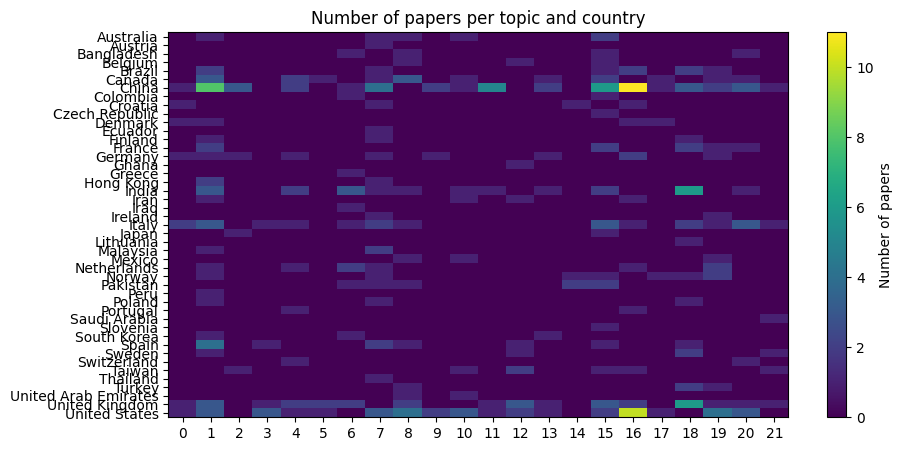

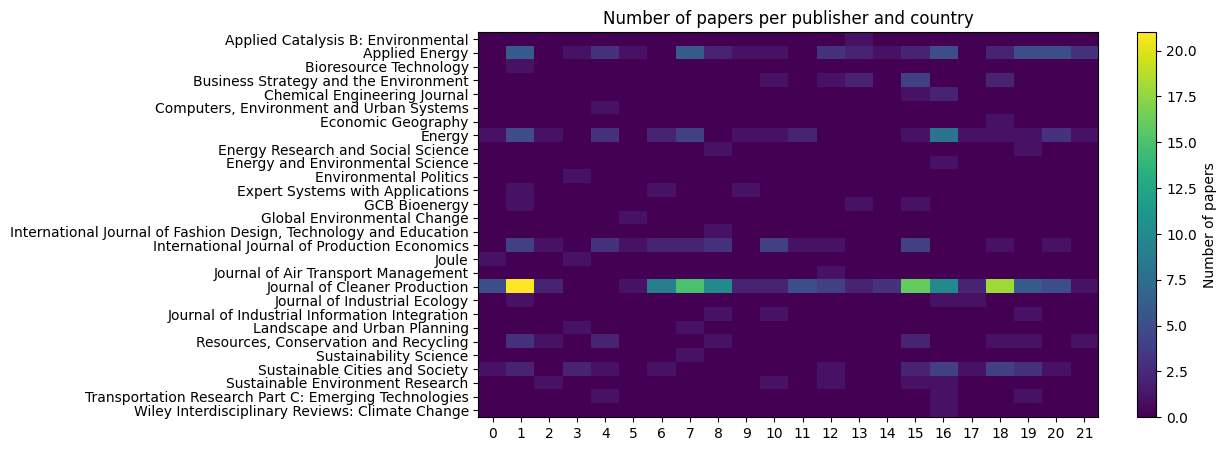

In [ ]:

country_year_counts = final_topic_df.groupby(['Country', 'Topic']).size().unstack().fillna(0)
# country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 300]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
plt.figure(figsize=(10,5))
plt.imshow(country_year_counts, aspect='auto')
plt.yticks(range(len(country_year_counts)), country_year_counts.index)
plt.xticks(range(len(country_year_counts.columns)), country_year_counts.columns)
plt.title('Number of papers per topic and country')
plt.colorbar(label='Number of papers')
plt.show()

country_year_counts = final_topic_df.groupby(['Publisher', 'Topic']).size().unstack().fillna(0)
# country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 400]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
plt.figure(figsize=(10,5))
plt.imshow(country_year_counts, aspect='auto')
plt.yticks(range(len(country_year_counts)), country_year_counts.index)
plt.xticks(range(len(country_year_counts.columns)), country_year_counts.columns)
plt.title('Number of papers per publisher and country')
plt.colorbar(label='Number of papers')
plt.show()


### The following are the results generated by ChatGPT according to the LDA result, it gives an overview of the current research trends in the field, and the potential future research directions.
### This is a useful tool for researchers to quickly understand the current state of the field and identify potential research gaps and opportunities.

# Topic Modeling Results

The following topics were derived from a list of papers. Each topic is summarized with its key keywords and a brief interpretation of its focus.

---

## Topic 0 – Food & Agricultural Supply Chain Sustainability
**Keywords:** data, kg, artichoke, chain, emission, sustainability, supply, transportation, environmental  
**Description:** Focus on data-driven analysis in agricultural or food supply chains with sustainability and emission implications.

---

## Topic 1 – Transportation Emissions & Electric Vehicles
**Keywords:** emission, carbon, vehicle, supply, transportation, chain, electric, energy  
**Description:** Emphasizes vehicle emissions, carbon issues, and the shift toward electric transportation systems.

---

## Topic 2 – Circular Economy and Recycling in Transportation
**Keywords:** emission, reuse, recycling, lsp, network, transportation, product, carbon, system  
**Description:** Focuses on reuse, recycling, and circular strategies to reduce emissions in transportation networks.

---

## Topic 3 – Fuel Economics & Decarbonization Strategies
**Keywords:** cost, fuel, local, delivery, carbon, lhv, emission, decarbonization, petroleum, price  
**Description:** Highlights fuel pricing, cost analysis, and decarbonization strategies in local delivery or transport contexts.

---

## Topic 4 – Transportation Technology & Emissions Modeling
**Keywords:** vehicle, emission, model, fuel, transportation, technology, electricity, energy, supply, digital  
**Description:** Centers on advanced modeling of transportation systems that integrate fuel technologies and digital solutions.

---

## Topic 5 – Alternative Fuels & Bioethanol Policy
**Keywords:** carbon, fuel, bioethanol, policy, chain, supply, alternative, emission, marine  
**Description:** Examines bioethanol and alternative fuels within policy frameworks affecting supply chains, including marine transport.

---

## Topic 6 – Sustainable Supply Chain Management
**Keywords:** chain, supply, model, emission, study, challenge, sustainability, industry, cost, development  
**Description:** Focuses on supply chain modeling and strategies for sustainability and emission control in industrial processes.

---

## Topic 7 – Energy Production & Emission Systems
**Keywords:** energy, emission, sector, production, system, chain, supply, study, technology, carbon  
**Description:** Emphasizes energy production processes and integrated emission management systems across sectors.

---

## Topic 8 – Environmental Cost Modeling & Sustainability
**Keywords:** cost, model, carbon, environmental, emission, network, chain, total, supply, sustainability  
**Description:** Centers on assessing cost models for carbon emissions and overall environmental sustainability.

---

## Topic 9 – Wine Logistics & Transportation Algorithms
**Keywords:** wine, vehicle, ev, network, algorithm, transportation, isc, cost, depot, logistics  
**Description:** Focuses on niche supply chain logistics, exemplified by wine distribution and the use of algorithmic optimization.

---

## Topic 10 – Circular Supply Chain Strategy
**Keywords:** supply, chain, model, circular, industry, emission, strategy, demand, energy, profit  
**Description:** Highlights circular economy approaches within supply chains to optimize strategy and reduce emissions.

---

## Topic 11 – Urban Mobility & Emission Performance
**Keywords:** emission, carbon, study, building, performance, mobility, supply, chain, ptl, sustainability  
**Description:** Focuses on urban environments—linking building performance and mobility with emission and sustainability outcomes.

---

## Topic 12 – Supply Chain Emissions & Waste Management
**Keywords:** supply, chain, emission, carbon, product, waste, study, fuel, transportation  
**Description:** Explores the interplay between product supply, waste management, and associated carbon/emission impacts.

---

## Topic 13 – Power Plant Emission & Fuel Transition
**Keywords:** carbon, supply, power_plant, chain, environmental, coal, fuel, renewable, water  
**Description:** Examines emissions from power plants, contrasting coal with renewable fuels and addressing environmental transitions.

---

## Topic 14 – National Energy & Economic Growth
**Keywords:** energy, country, index, per_caput, income, growth, need, region, supply, biomass  
**Description:** Relates national or regional energy profiles with economic indicators like income and growth, incorporating biomass energy.

---

## Topic 15 – Corporate Emission Scenarios & Environmental Impact
**Keywords:** emission, carbon, transportation, study, environmental, scenario, effect, firm, production  
**Description:** Focuses on corporate-level emission scenarios and their environmental implications within production and transport sectors.

---

## Topic 16 – Energy Systems & Emission Reduction
**Keywords:** emission, energy, carbon, system, scenario, transportation, technology, reduction, industry, study  
**Description:** Deals with integrated energy systems and technological strategies aimed at reducing emissions across industries.

---

## Topic 17 – Hydrogen Energy & Regulatory Frameworks
**Keywords:** system, hydrogen, certification, production, power, environmental, renewable, location, energy, regulation  
**Description:** Centers on hydrogen as an energy source, examining its production, certification, and the related regulatory frameworks.

---

## Topic 18 – Sustainable Transportation Policy & Practice
**Keywords:** emission, transport, sustainable, carbon, study, sustainability, development, chain, policy, practice  
**Description:** Focuses on policies and practices that promote sustainability in transportation and reduce carbon emissions.

---

## Topic 19 – Urban Energy Systems & Emission Impact Analysis
**Keywords:** system, emission, cost, city, result, impact, study, delivery, power, model  
**Description:** Examines urban energy systems, cost implications of emissions, and their impact on city environments.

---

## Topic 20 – Future Energy & Hydrogen Mobility
**Keywords:** hydrogen, energy, renewable, ev, vehicle, transportation, system, development, future, planning  
**Description:** Envisions the future integration of hydrogen, renewable energy, and electric vehicles into evolving transport systems.

---

## Topic 21 – Urban Emission Policy & Ecosystem Management
**Keywords:** system, urban, emission, policy, consumption, chain, study, production, ecosystem, management  
**Description:** Focuses on managing urban emissions through integrated policies and ecosystem-based approaches within supply chains.


### Show trends of each topic